GPR Model:

5 parts

The first part contains the imports as well as a modified GPR that has an increased max_iter

The second part is the main code which actually contains the GPR function and runs the MCCV loop (set to 1000 iterations with 90/10 train test)  but can be changed via n_splits and test_fraction

The third part is the predicted versus actual plot 

The fourth part is the prediction part which contains the GPR prediction of the 4851 dataset of different molecules

The fifth part is optional and it removes all the molecules that were in the training set from the large predicted set (to avoid artifically better results)


In [7]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.pipeline import Pipeline
import scipy.optimize


class MyGPR(GaussianProcessRegressor):
    def __init__(self, kernel=None, alpha=1e-15, optimizer="fmin_l_bfgs_b",
                 n_restarts_optimizer=0, normalize_y=False, copy_X_train=True,
                 random_state=None, max_iter=1000000, gtol=1e-6):
        super().__init__(kernel=kernel, alpha=alpha, optimizer=optimizer,
                         n_restarts_optimizer=n_restarts_optimizer, normalize_y=normalize_y,
                         copy_X_train=copy_X_train, random_state=random_state)
        self.max_iter = max_iter
        self.gtol = gtol

    def _constrained_optimization(self, obj_func, initial_theta, bounds):
        if self.optimizer == "fmin_l_bfgs_b":
            opt_res = scipy.optimize.minimize(
                obj_func, initial_theta, method="L-BFGS-B", jac=True, bounds=bounds,
                tol=self.gtol, options={'maxiter': self.max_iter, 'disp': True}
            )
            theta_opt, func_min = opt_res.x, opt_res.fun
        elif callable(self.optimizer):
            theta_opt, func_min = self.optimizer(obj_func, initial_theta, bounds=bounds)
        else:
            raise ValueError(f"Unknown optimizer {self.optimizer}.")

        return theta_opt, func_min

In [8]:
data = pd.read_csv("data.csv")


numeric_features = ['ionic_character_2nd_root', 'Diff_Ionic_4th_root','Sum_Affinity','Prod_Ionic_Recip']
categorical_features = ['Group1', 'Group2', 'Period1', 'Period2']
target = 'dipole_moment'
molecule_column = 'Molecule' ##For Grouping##

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features), 
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
    ]
)

X = preprocessor.fit_transform(data[numeric_features + categorical_features])
y = data[target].values.flatten()
molecules = data[molecule_column].values # This will be used for grouping

# --- GPR Kernel Setup ---
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

# --- MCCV Parameters ---
n_splits = 1000
test_fraction = 0.1 

# --- Aggregation Dictionaries ---
all_predictions_test = {}
all_predictions_train = {}
rmse_train_values = []
rmse_test_values = []
mae_train_values = []
mae_test_values = []
per_sample_test_errors = {}
per_sample_train_errors = {}
lower_bounds_test = {}
upper_bounds_test = {}

unique_molecules = np.unique(molecules)
n_total_unique_molecules = len(unique_molecules)
n_test_molecules = int(test_fraction * n_total_unique_molecules)
n_train_molecules = n_total_unique_molecules - n_test_molecules

true_iteration = 0
attempt = 0
max_attempts = 10000

print(f"Total unique molecules: {n_total_unique_molecules}")
print(f"Number of test molecules per fold: {n_test_molecules}")
print(f"Number of training molecules per fold: {n_train_molecules}")

while true_iteration < n_splits and attempt < max_attempts:
    attempt += 1

    # Randomly select molecules for the test set
    test_molecules_sample = np.random.choice(unique_molecules, size=n_test_molecules, replace=False)
    train_molecules_sample = np.array(list(set(unique_molecules) - set(test_molecules_sample)))

    # Get indices for training and test sets based on molecule names
    train_index = np.where(np.isin(molecules, train_molecules_sample))[0]
    test_index = np.where(np.isin(molecules, test_molecules_sample))[0]

    if len(test_index) == 0 or len(train_index) == 0:
        if n_test_molecules == 0 or n_train_molecules == 0:
            print("Warning: n_test_molecules or n_train_molecules is 0. Adjusting test_fraction or dataset size might be needed.")
            break
        continue

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    gpr = MyGPR(kernel=kernel, alpha=0.01, normalize_y=True, n_restarts_optimizer=10)
    gpr.fit(X_train, y_train)

    y_test_pred, y_test_std = gpr.predict(X_test, return_std=True)
    y_train_pred, _ = gpr.predict(X_train, return_std=True)

    for j, original_idx in enumerate(test_index):
        all_predictions_test.setdefault(original_idx, []).append(y_test_pred[j])
        lower_bounds_test.setdefault(original_idx, []).append(y_test_pred[j] - y_test_std[j])
        upper_bounds_test.setdefault(original_idx, []).append(y_test_pred[j] + y_test_std[j])
        per_sample_test_errors[original_idx] = per_sample_test_errors.get(original_idx, []) + [(y[original_idx] - y_test_pred[j])**2]

    for j, original_idx in enumerate(train_index):
        all_predictions_train.setdefault(original_idx, []).append(y_train_pred[j])
        per_sample_train_errors[original_idx] = per_sample_train_errors.get(original_idx, []) + [(y[original_idx] - y_train_pred[j])**2]

    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)

    rmse_train_values.append(rmse_train)
    rmse_test_values.append(rmse_test)
    mae_train_values.append(mae_train)
    mae_test_values.append(mae_test)

    true_iteration += 1
    if true_iteration % 10 == 0 or true_iteration == 1:
        print(f"Iteration {true_iteration} of {n_splits} (attempt {attempt}): "
              f"RMSE Train: {rmse_train:.4f}, RMSE Test: {rmse_test:.4f}, "
              f"MAE Train: {mae_train:.4f}, MAE Test: {mae_test:.4f}")

if true_iteration < n_splits:
    print(f"Warning: Could not complete {n_splits} iterations. Only {true_iteration} completed.")

def aggregate_predictions(pred_dict, original_y_values):
    actuals, avg_preds, std_preds, sorted_indices = [], [], [], []
    for index in sorted(pred_dict.keys()):
        preds = pred_dict[index]
        avg_preds.append(np.mean(preds))
        std_preds.append(np.std(preds))
        actuals.append(original_y_values[index])
        sorted_indices.append(index)
    return sorted_indices, actuals, avg_preds, std_preds

def aggregate_bounds(bound_dict):
    avg_bounds = []
    for index in sorted(bound_dict.keys()):
        bounds = bound_dict[index]
        avg_bounds.append(np.mean(bounds))
    return avg_bounds

sorted_indices_test, actuals_test, avg_preds_test, std_preds_test = aggregate_predictions(all_predictions_test, y)
sorted_indices_train, actuals_train, avg_preds_train, std_preds_train = aggregate_predictions(all_predictions_train, y)
avg_lower_bounds_test = aggregate_bounds(lower_bounds_test)
avg_upper_bounds_test = aggregate_bounds(upper_bounds_test)

results_df_test = pd.DataFrame({
    'index': sorted_indices_test,
    'molecule': [molecules[idx] for idx in sorted_indices_test],
    'actual': actuals_test,
    'average_prediction': avg_preds_test,
    'standard_deviation': std_preds_test,
    'avg_lower_bound': avg_lower_bounds_test,
    'avg_upper_bound': avg_upper_bounds_test
})

results_df_train = pd.DataFrame({
    'index': sorted_indices_train,
    'molecule': [molecules[idx] for idx in sorted_indices_train],
    'actual': actuals_train,
    'average_prediction': avg_preds_train,
    'standard_deviation': std_preds_train
})

results_df_test.to_csv('mccv_test_results.csv', index=False)
results_df_train.to_csv('mccv_train_results.csv', index=False)

final_rmse_test = np.sqrt(np.mean([np.mean(sq_errors) for sq_errors in per_sample_test_errors.values()]))
final_rmse_train = np.sqrt(np.mean([np.mean(sq_errors) for sq_errors in per_sample_train_errors.values()]))

print("MCCV results saved to mccv_test_results.csv and mccv_train_results.csv")
print(f"Overall Average Training RMSE: {np.mean(rmse_train_values):.4f}")
print(f"Overall Average Testing RMSE: {np.mean(rmse_test_values):.4f}")
print(f"Training RMSE Std Dev: {np.std(rmse_train_values):.4f}")
print(f"Testing RMSE Std Dev: {np.std(rmse_test_values):.4f}")
print(f"Min/Max Train RMSE: {np.min(rmse_train_values):.4f} / {np.max(rmse_train_values):.4f}")
print(f"Min/Max Test RMSE: {np.min(rmse_test_values):.4f} / {np.max(rmse_test_values):.4f}")
print("---")
print(f"Final Aggregated Training RMSE: {final_rmse_train:.4f}")
print(f"Final Aggregated Testing RMSE: {final_rmse_test:.4f}")
print("---")
print(f"Overall Average Training MAE: {np.mean(mae_train_values):.4f}")
print(f"Overall Average Testing MAE: {np.mean(mae_test_values):.4f}")
print(f"Training MAE Std Dev: {np.std(mae_train_values):.4f}")
print(f"Testing MAE Std Dev: {np.std(mae_test_values):.4f}")
print(f"Min/Max Train MAE: {np.min(mae_train_values):.4f} / {np.max(mae_train_values):.4f}")
print(f"Min/Max Test MAE: {np.min(mae_test_values):.4f} / {np.max(mae_test_values):.4f}")


Total unique molecules: 273
Number of test molecules per fold: 27
Number of training molecules per fold: 246
Iteration 1 of 1000 (attempt 1): RMSE Train: 0.1045, RMSE Test: 0.4795, MAE Train: 0.0733, MAE Test: 0.3736
Iteration 10 of 1000 (attempt 10): RMSE Train: 0.1102, RMSE Test: 0.6801, MAE Train: 0.0757, MAE Test: 0.5515
Iteration 20 of 1000 (attempt 20): RMSE Train: 0.1069, RMSE Test: 0.6962, MAE Train: 0.0749, MAE Test: 0.4640
Iteration 30 of 1000 (attempt 30): RMSE Train: 0.1024, RMSE Test: 0.5153, MAE Train: 0.0716, MAE Test: 0.3658
Iteration 40 of 1000 (attempt 40): RMSE Train: 0.1081, RMSE Test: 0.6171, MAE Train: 0.0753, MAE Test: 0.5009
Iteration 50 of 1000 (attempt 50): RMSE Train: 0.1014, RMSE Test: 0.9750, MAE Train: 0.0739, MAE Test: 0.6409
Iteration 60 of 1000 (attempt 60): RMSE Train: 0.0999, RMSE Test: 0.6407, MAE Train: 0.0731, MAE Test: 0.4111
Iteration 70 of 1000 (attempt 70): RMSE Train: 0.1081, RMSE Test: 0.6104, MAE Train: 0.0759, MAE Test: 0.3822
Iteration 80 

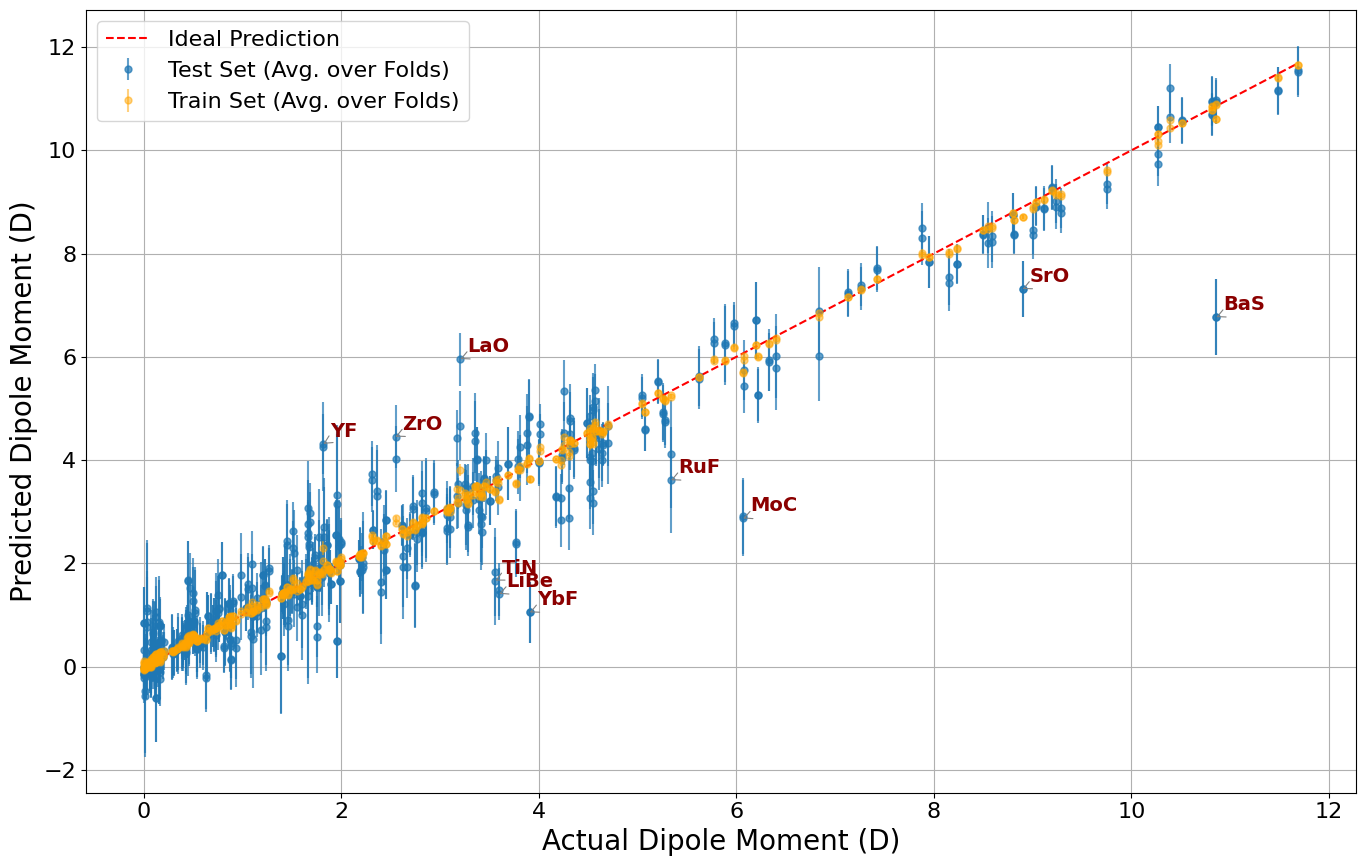

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
results_df_test = pd.read_csv("mccv_test_results.csv")
results_df_train = pd.read_csv("mccv_train_results.csv")

# Compute absolute error
results_df_test['abs_error'] = np.abs(results_df_test['actual'] - results_df_test['average_prediction'])

# Set up high-res plot with larger font sizes
plt.figure(figsize=(14, 9))
plt.rcParams.update({
    'font.size': 18,
    'axes.labelsize': 20,
    'axes.titlesize': 20,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16
})

# Plot Test Set
plt.errorbar(
    results_df_test['actual'], results_df_test['average_prediction'],
    yerr=[results_df_test['average_prediction'] - results_df_test['avg_lower_bound'],
          results_df_test['avg_upper_bound'] - results_df_test['average_prediction']],
    fmt='o', markersize=5, alpha=0.7, label='Test Set (Avg. over Folds)'
)

# Plot Train Set
plt.errorbar(
    results_df_train['actual'], results_df_train['average_prediction'],
    yerr=results_df_train['standard_deviation'],
    fmt='o', color='orange', markersize=5, alpha=0.5, label='Train Set (Avg. over Folds)'
)

# Plot Ideal Line
min_val = min(results_df_test['actual'].min(), results_df_train['actual'].min())
max_val = max(results_df_test['actual'].max(), results_df_train['actual'].max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Prediction')

# Labels and layout
plt.xlabel('Actual Dipole Moment (D)')
plt.ylabel('Predicted Dipole Moment (D)')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Annotate top 10 outliers (unique molecules only)
outliers_df = results_df_test.sort_values(by='abs_error', ascending=False)
seen_molecules = set()
labeled_count = 0

for _, row in outliers_df.iterrows():
    molecule = row['molecule']
    if molecule not in seen_molecules:
        seen_molecules.add(molecule)
        plt.annotate(
            molecule,
            (row['actual'], row['average_prediction']),
            textcoords="offset points",
            xytext=(5, 5),
            ha='left',
            fontsize=14,
            fontweight='bold',
            color='darkred',
            arrowprops=dict(arrowstyle='->', color='gray', lw=0.8)
        )
        labeled_count += 1
    if labeled_count >= 10:
        break

# Save and show
plt.savefig('dipole_moment_prediction_GPR.pdf', bbox_inches='tight')
plt.show()


In [5]:

# ---- Load datasets ----
train_data = pd.read_csv("data.csv")
big_set = pd.read_csv("large_set.csv")


numeric_features = ['ionic_character_2nd_root', 'Diff_Ionic_4th_root','Sum_Affinity','Prod_Ionic_Recip']
categorical_features = ['Group1', 'Group2', 'Period1', 'Period2']
target = 'dipole_moment'

# ---- Column Transformer for preprocessing ----
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features)
    ]
)

# ---- Prepare features ----
X_train = train_data[numeric_features + categorical_features]
y_train = train_data[target].values.flatten()
X_big = big_set[numeric_features + categorical_features]

# ---- Preprocess data ----
X_train_processed = preprocessor.fit_transform(X_train)
X_big_processed = preprocessor.transform(X_big)

# ---- Kernel Setup: Simple RBF ----
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

gpr = MyGPR(kernel=kernel, alpha=0.01, normalize_y=True, n_restarts_optimizer=10)

# ---- Train on full dataset ----
gpr.fit(X_train_processed, y_train)

# ---- Predict on big_set ----
y_big_pred, y_big_std = gpr.predict(X_big_processed, return_std=True)

# ---- Save results ----
big_set_results = big_set.copy()
big_set_results['predicted_dipole_moment'] = y_big_pred
big_set_results['std_dev'] = y_big_std
big_set_results['lower_bound'] = y_big_pred - y_big_std
big_set_results['upper_bound'] = y_big_pred + y_big_std

big_set_results.to_csv("GPR_predictions.csv", index=False)
print("Predictions with uncertainty saved to GPR_predictions.csv")


Predictions with uncertainty saved to GPR_predictions.csv


In [6]:
df1=pd.read_csv("data.csv")
df2=pd.read_csv("GPR_predictions.csv")
pairs_df1 = set(tuple(sorted([row['atom 1'], row['atom 2']])) for _, row in df1.iterrows())
mask = df2.apply(lambda row: tuple(sorted([row['Atom 1'], row['Atom 2']])) not in pairs_df1, axis=1)
df2_filtered = df2[mask].reset_index(drop=True)
df2_filtered.to_csv("GPR_predictions_no_training.csv",index=False)

